# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

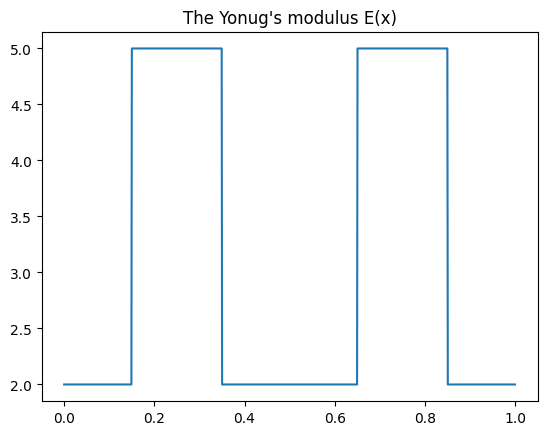

In [1]:
import numpy as np
import matplotlib.pyplot as  plt

def E(x, phase1=2., phase2=5.):
    '''Young's modulus'''
    return np.where(np.abs(x-0.5)<0.35, np.where(np.abs(x-0.5)>0.15, phase2, phase1), phase1)
#
x = np.linspace(0., 1., 1000)
e = E(x)
#
plt.figure()
plt.plot(x,e)
plt.title("The Yonug's modulus E(x)")
plt.show()


L² relativer Fehler: 0.14336295


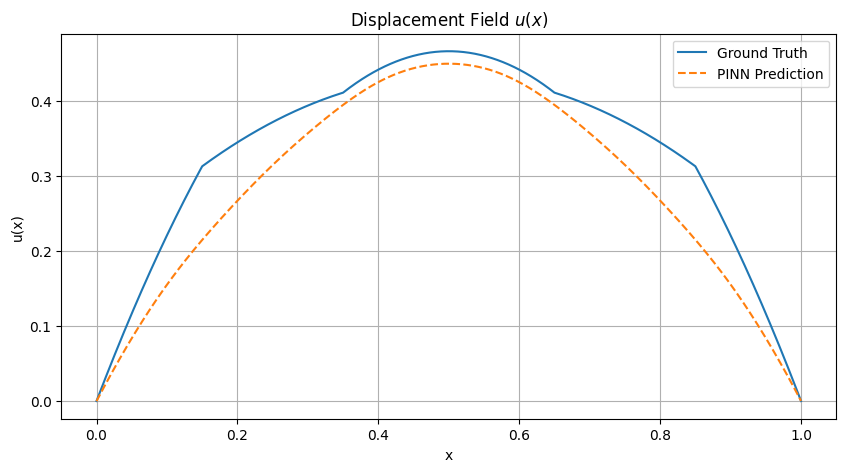

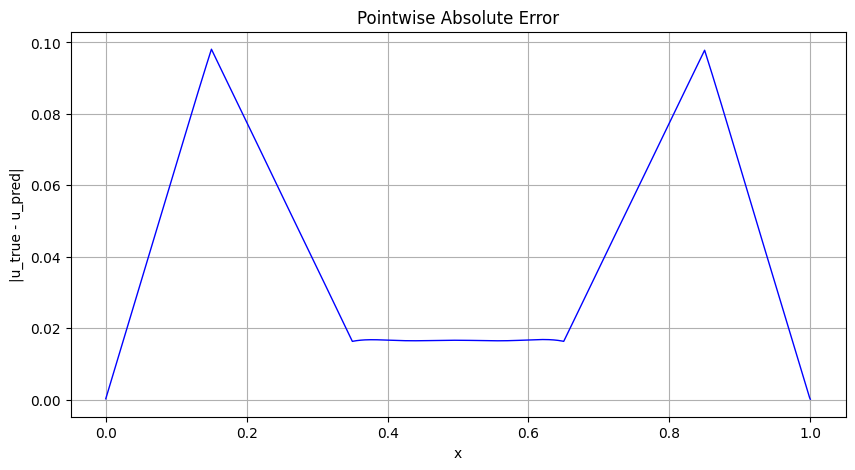

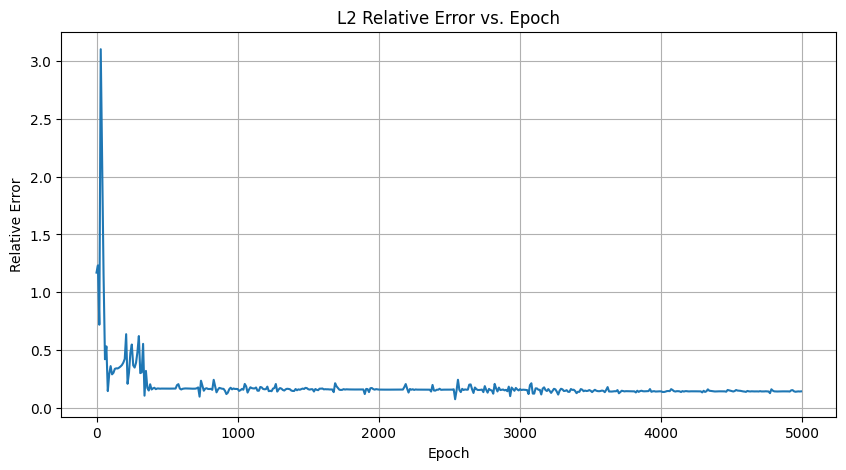

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Load test data from HDF5 file
# File contains test inputs 'x_test' and the corresponding displacements 'u_test'
with h5py.File("LinearElasticity1d.h5", 'r') as f:
    x_test = f['x_test'][:]
    u_test = f['u_test'][:]

# Set device to GPU if available, otherwise fall back to CPU -> I only have CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# For reproducibility: fix the random seed
torch.manual_seed(42)

# Convert test data to PyTorch tensors
# Enable gradient tracking for x_test_tensor, for differentiating w.r.t x
x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device, requires_grad=True)
u_test_tensor = torch.tensor(u_test, dtype=torch.float32, device=device)

# Define the spatially varying material property E(x)
# E(x) switches between 2.0 and 5.0 depending on the location within the domain
def E(x):
    return torch.where((torch.abs(x - 0.5) > 0.15) & (torch.abs(x - 0.5) < 0.35),
                       torch.tensor(5.0, device=device),
                       torch.tensor(2.0, device=device))

# Fully connected neural network model
class FCNN(nn.Module):
    def __init__(self, layers):
        super(FCNN, self).__init__()
        # tanh as activation function for the whole network
        self.activation = torch.tanh
        self.linears = nn.ModuleList()
        
        # Construct linear layers
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        
        # Initialize weights using Xavier initialization
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight.data)

    def forward(self, x):
        # Forward pass: linear layers and tanh activations (except last layer)
        for i in range(len(self.linears) - 1):
            x = self.activation(self.linears[i](x))
        return self.linears[-1](x)

# Define physics-based residual of PDE
def pde_residual(x):
    # Enablig Gradients for x
    x.requires_grad_(True)
    u = model(x)
    
    # First derivative of u with respect to x
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    
    # Multiply with E(x)
    E_x = E(x)
    E_du = E_x * du
    
    # Compute derivative of (E(x) * du/dx)
    d_Edu = torch.autograd.grad(E_du, x, torch.ones_like(E_du), create_graph=True)[0]
    
    # Final residual: corresponds to the strong form of the PDE
    return -d_Edu - 9.81  # gravity

# Loss function combines PDE residual and Dirichlet boundary conditions
def loss_fn(x_colloc, x_bc, u_bc):
    res = pde_residual(x_colloc)
    loss_pde = torch.mean(res**2)  # MPDE loss
    
    u_pred_bc = model(x_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)  # Boundary condition loss
    
    return loss_pde + loss_bc  # Total loss

# Generate collocation points in the domain [0, 1]
x_colloc = torch.linspace(0, 1, 1000, device=device).view(-1, 1).requires_grad_()

# Boundary condition points and values
x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32, device=device)  # endpoints
u_bc = torch.tensor([[0.0], [0.0]], dtype=torch.float32, device=device)  # Dirichlet BCs: u=0 at both ends

# neural network model and optimizer
layers = [1, 128, 128, 128, 1]  # 3 hidden layers with 128 neurons each
model = FCNN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000  # total training epochs
errors = []  # store L2 errors

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_fn(x_colloc, x_bc, u_bc)
    loss.backward()
    optimizer.step()
    
    # Every 10 epochs, compute and record the relative L2 error on the test set
    if epoch % 10 == 0:
        with torch.no_grad():
            u_pred_test = model(x_test_tensor).squeeze()
            error = torch.sqrt(torch.sum((u_pred_test - u_test_tensor)**2) / torch.sum(u_test_tensor**2)).item()
            errors.append(error)

# After training, make a prediction on the test data
with torch.no_grad():
    u_pred_tensor = model(x_test_tensor).squeeze()
    u_pred = u_pred_tensor.cpu().numpy()
    u_test_np = u_test_tensor.cpu().numpy()

# Compute final relative L2 error between predicted and true displacements
l2_relative_error = np.sqrt(np.sum((u_pred - u_test_np)**2) / np.sum(u_test_np**2))
print("\nL² relativer Fehler:", l2_relative_error)

# Compute pointwise absolute error for visualization
pointwise_abs_error = np.abs(u_pred - u_test_np)

# Plot: Predicted vs. true displacement field
plt.figure(figsize=(10, 5))
plt.plot(x_test, u_test, label='Ground Truth')
plt.plot(x_test, u_pred, '--', label='PINN Prediction')
plt.legend()
plt.title('Displacement Field $u(x)$')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.show()

# Plot: Absolute error at each point
plt.figure(figsize=(10, 5))
plt.plot(x_test, pointwise_abs_error, color='blue', linewidth=1)
plt.title('Pointwise Absolute Error')
plt.xlabel('x')
plt.ylabel('|u_true - u_pred|')
plt.grid(True)
plt.show()

# Plot: Training curve (L2 error over time)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, epochs, 10), errors)
plt.title('L2 Relative Error vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Relative Error')
plt.grid(True)
plt.show()


## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>


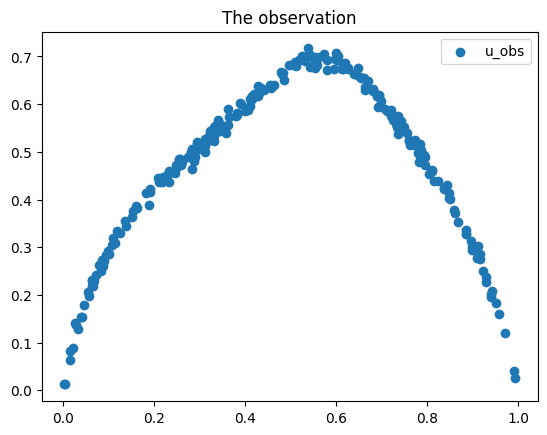

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
#
with h5py.File('LinearElasticity1d_inverse.h5', 'r') as file:
    print(file.keys())
    #
    x_obs = np.array(file['x_obs']).reshape(-1,1)
    u_obs = np.array(file['u_obs']).reshape(-1,1)
#
plt.figure()
plt.scatter(x_obs, u_obs, label='u_obs')
plt.title('The observation')
plt.legend()
plt.show()

Epoch 0: Loss = 4.8203e+02, RelError(E) = 7.0692e-01
Epoch 500: Loss = 1.8743e-01, RelError(E) = 5.9701e-01
Epoch 1000: Loss = 1.5731e-01, RelError(E) = 5.8921e-01
Epoch 1500: Loss = 1.5512e-01, RelError(E) = 5.8858e-01
Epoch 2000: Loss = 1.5287e-01, RelError(E) = 5.8791e-01
Epoch 2500: Loss = 1.5057e-01, RelError(E) = 5.8718e-01
Epoch 3000: Loss = 1.4815e-01, RelError(E) = 5.8630e-01
Epoch 3500: Loss = 1.4559e-01, RelError(E) = 5.8514e-01
Epoch 4000: Loss = 1.4346e-01, RelError(E) = 5.8397e-01
Epoch 4500: Loss = 1.4130e-01, RelError(E) = 5.8239e-01
Epoch 5000: Loss = 1.3882e-01, RelError(E) = 5.7996e-01
Epoch 5500: Loss = 2.0194e-01, RelError(E) = 5.7635e-01
Epoch 6000: Loss = 1.2151e-01, RelError(E) = 5.6487e-01
Epoch 6500: Loss = 1.0953e-01, RelError(E) = 5.5180e-01
Epoch 7000: Loss = 9.7267e-02, RelError(E) = 5.3679e-01
Epoch 7500: Loss = 8.6746e-02, RelError(E) = 5.2325e-01
Epoch 8000: Loss = 7.7233e-02, RelError(E) = 5.0997e-01
Epoch 8500: Loss = 6.8038e-02, RelError(E) = 4.9687e

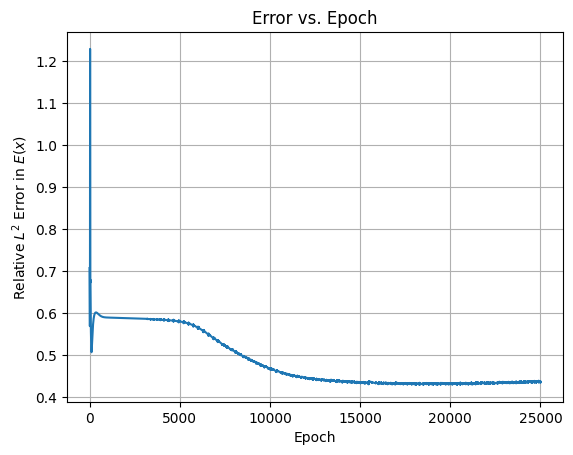

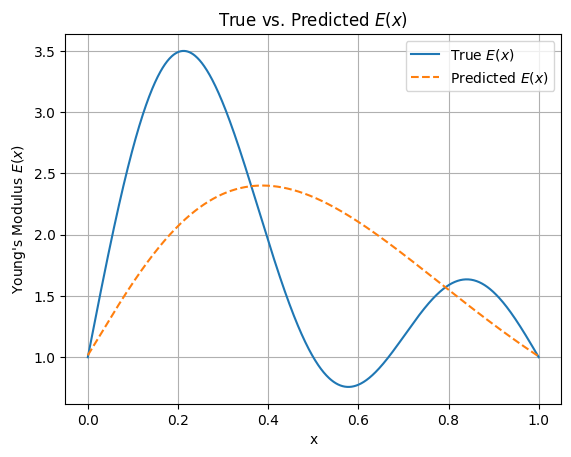

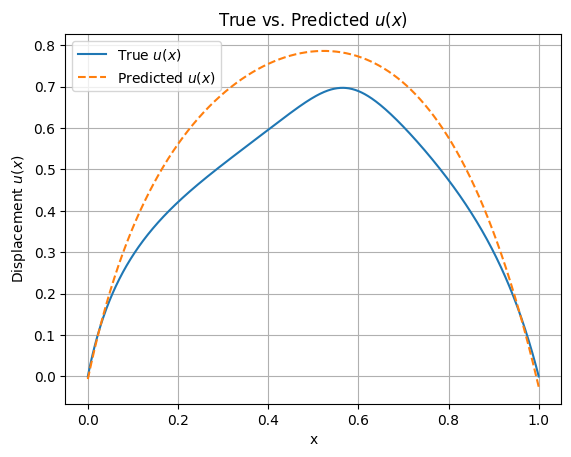

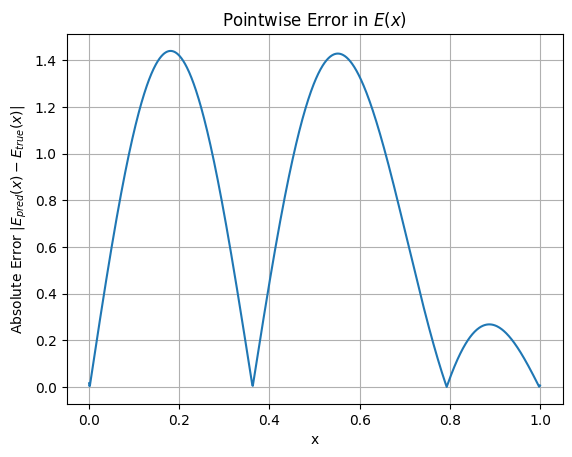

Final relative L2 error in E(x): 4.3538e-01


In [7]:
# Inverse PINN for 1D Linear Elasticity

import torch
import torch.nn as nn
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Set random seeds 
torch.manual_seed(0)
np.random.seed(0)

# Load dataset
# The file contains observed displacements, test data, and the ground truth for E(x)
with h5py.File("LinearElasticity1d_inverse.h5", "r") as f:
    x_obs = np.array(f["x_obs"])  
    u_obs = np.array(f["u_obs"])  
    x_test = np.array(f["x_test"]) 
    u_test = np.array(f["u_test"])    
    e_test = np.array(f["e_test"])      

# Convert data to PyTorch tensors for model input/output
x_obs_t = torch.tensor(x_obs, dtype=torch.float32).view(-1, 1).requires_grad_(True)
u_obs_t = torch.tensor(u_obs, dtype=torch.float32).view(-1, 1)
x_test_t = torch.tensor(x_test, dtype=torch.float32)
u_test_t = torch.tensor(u_test, dtype=torch.float32).view(-1, 1)
e_test_t = torch.tensor(e_test, dtype=torch.float32)
f_val = 9.81  # gravity

# Define collocation points (for enforcing the PDE)
x_colloc = torch.linspace(0, 1, 500).view(-1, 1).requires_grad_(True)

# Define neural networks with soft boundary conditions
# Network to learn E(x), the spatially varying Young’s modulus
class NetE(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128), nn.SiLU(),  # First hidden layer
            nn.Linear(128, 128), nn.SiLU(),  # Second hidden layer
            nn.Linear(128, 128), nn.SiLU(),  # Third hidden layer
            nn.Linear(128, 1),
            nn.Softplus()  # Ensures E(x) > 0, which is physically required
        )
        self._init_weights()

    # Custom weight initialization for better convergence
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x) 

# Network to learn u(x), the displacement field
class NetU(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.SiLU(),
            nn.Linear(64, 64), nn.SiLU(),
            nn.Linear(64, 64), nn.SiLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x) 

# Training Setup
# Instantiate both networks
net_E = NetE()
net_U = NetU()

# Combine parameters from both networks for joint optimization
params = list(net_E.parameters()) + list(net_U.parameters())

# Adam optimizer, standard choice for PINNs
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()  # Mean squared error

# Loss weights
lambda_data = 1.0
lambda_pde = 5.0  
lambda_bc = 5.0  

epochs = 25000  # Number of training steps
errors = []     # track error during training

# === Training loop ===
for epoch in range(epochs):
    optimizer.zero_grad()

    # Predict displacement at observation points
    u_pred_obs = net_U(x_obs_t)

    # Predict E(x) and u(x) at the collocation points
    e_pred_col = net_E(x_colloc)
    u_pred_col = net_U(x_colloc)

    # Compute spatial derivative du/dx using autograd
    du_dx = torch.autograd.grad(u_pred_col, x_colloc, grad_outputs=torch.ones_like(u_pred_col),
                                create_graph=True, retain_graph=True)[0]

    # Multiply E(x) * du/dx for the PDE
    E_du = e_pred_col * du_dx

    # Compute spatial derivative d/dx of (E(x) * du/dx)
    dEdudx = torch.autograd.grad(E_du, x_colloc, grad_outputs=torch.ones_like(E_du),
                                 create_graph=True, retain_graph=True)[0]

    # gives residual of the PDE: -d/dx(E * du/dx) = f
    pde_residual = -dEdudx - f_val

    # Compute losses
    loss_pde = loss_fn(pde_residual, torch.zeros_like(pde_residual))  # Physics loss
    loss_data = loss_fn(u_pred_obs, u_obs_t)                           # Data loss

    # Soft boundary conditions
    x0 = torch.tensor([[0.0]], dtype=torch.float32)
    x1 = torch.tensor([[1.0]], dtype=torch.float32)
    u0 = net_U(x0)
    u1 = net_U(x1)
    e0 = net_E(x0)
    e1 = net_E(x1)

    # u(0) = 0, u(1) = 0 and E(0) = 1, E(1) = 1
    loss_bc = loss_fn(u0, torch.zeros_like(u0)) + \
              loss_fn(u1, torch.zeros_like(u1)) + \
              loss_fn(e0, torch.ones_like(e0)) + \
              loss_fn(e1, torch.ones_like(e1))

    # Total loss combines data, physics, and boundary losses
    loss = lambda_data * loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Evaluate relative L2 error on the test set for E(x)
    with torch.no_grad():
        e_pred_test = net_E(x_test_t)
        err = torch.sqrt(torch.sum((e_pred_test - e_test_t) ** 2) / torch.sum(e_test_t ** 2)).item()
        errors.append(err)

    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}, RelError(E) = {err:.4e}")



# After training: evaluation and plots
with torch.no_grad():
    e_pred_test = net_E(x_test_t)
    u_pred_test = net_U(x_test_t)

# Plot how the error evolved over epochs
plt.figure()
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Relative $L^2$ Error in $E(x)$")
plt.title("Error vs. Epoch")
plt.grid()
plt.show()

# Compare predicted vs. true E(x)
plt.figure()
plt.plot(x_test, e_test, label="True $E(x)$")
plt.plot(x_test, e_pred_test.detach().numpy(), '--', label="Predicted $E(x)$")
plt.xlabel("x")
plt.ylabel("Young's Modulus $E(x)$")
plt.legend()
plt.title("True vs. Predicted $E(x)$")
plt.grid()
plt.show()

# Compare predicted vs. true u(x)
plt.figure()
plt.plot(x_test, u_test, label="True $u(x)$")
plt.plot(x_test, u_pred_test.detach().numpy(), '--', label="Predicted $u(x)$")
plt.xlabel("x")
plt.ylabel("Displacement $u(x)$")
plt.legend()
plt.title("True vs. Predicted $u(x)$")
plt.grid()
plt.show()

# Pointwise absolute error for E(x)
plt.figure()
plt.plot(x_test, np.abs(e_pred_test.detach().numpy() - e_test))
plt.xlabel("x")
plt.ylabel("Absolute Error $|E_{pred}(x) - E_{true}(x)|$")
plt.title("Pointwise Error in $E(x)$")
plt.grid()
plt.show()

# Final error output
print(f"Final relative L2 error in E(x): {errors[-1]:.4e}")
